In [22]:
import numpy as np
import pandas as pd


# Plotly and Cufflinks Packages
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly import __version__
#For cufflinks on notebook
import cufflinks as cf
# For offline use
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)



# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns


# Other Libraries
import warnings
warnings.filterwarnings("ignore")

In [188]:
%matplotlib inline

# PROJECT OVERVIEW

Business objective: To improve loan risk prediction for a given loan applicant 


Understanding of loan risk: 5 main factors bank use to determine a loan risk 

1) Payment History

- Includes punctuality in terms of payment  
- Payment Issues 
- Fraud Score (included in given data)

2) Debt Level 

- Ratio of credit card balance to cc limit 

3) Credit History 

- Age of Credit Account in years
- Average loan APR (included in given data)

4) Type of credits 

- Credit types diversity (mortgage, car) 

5) Number of credit inquiries 

- Number of loans inquiries currently (included in given data)

Data given to me covers some of these factors, but should be sufficient to build a valuable model


        
        
   

# Setting up loan.csv
There are 21 different statuses in the 'loanStatus' columns. Without much insights on each statuses, I only assigned some of these 21 statuses into either bad loans and good loans based on my prior knowledge and understanding on how loan works


In [290]:
loan = pd.read_csv('loan.csv',parse_dates=['applicationDate','originatedDate']) #parse_date since those 2 columns is an object type)

In [291]:
loan_copy=loan #copy for future exploration 

In [294]:
loanId=loan.loanId

In [295]:
loanId['LL-I-07399092']='test'

In [297]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   loanId                            577426 non-null  object        
 1   anon_ssn                          577682 non-null  object        
 2   payFrequency                      576409 non-null  object        
 3   apr                               573760 non-null  float64       
 4   applicationDate                   577682 non-null  datetime64[ns]
 5   originated                        577682 non-null  bool          
 6   originatedDate                    46044 non-null   datetime64[ns]
 7   nPaidOff                          577658 non-null  float64       
 8   approved                          577682 non-null  bool          
 9   isFunded                          577682 non-null  int64         
 10  loanStatus                      

In [298]:
loan['loanStatus'].value_counts()

Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Application                 4
Pending Rescind                     4
Voided New Loan                     2
Customver Voided New Loan           1
Charged Off                         1
Settlement Pending Paid Off         1
Name: loanStatus, dtype: int64

In [299]:
'''
Setting a target variable. 0 for good/paid off loans 1 for default/bad loans 
Here I consider external collection as bad loans, since such process usually requires third party debt collection 
agency, which means our company's profit margin from that loan reduces by a certain amount
I considered Settlement Paid off as bad loans, since they are loans that are paid less than the total amount
'''
bad_loan = ["Charged Off", "Settled Bankruptcy","External Collection","Settlement Paid Off"]
good_loan = ["Paid Off Loan"]

loan['target'] = np.nan

def set_target(x):
    if x in bad_loan:
        return 1
    elif x in good_loan:
        return 0
    
    
loan['target'] = loan['loanStatus'].apply(set_target)

In [300]:
loan.drop('loanStatus',inplace=True,axis=1)

In [301]:
loan = loan[loan['target'].notna()].reset_index(drop=True)

In [302]:
loan['target'] = loan['target'].astype(int)

In [303]:
#Data seems pretty balanced to me, but will still consider using SMOTE for our model 
loan['target'].value_counts() 

1    12369
0    11427
Name: target, dtype: int64

# Data Exploration and Visualization with loan.csv

I created a:

a) Heatmap to ease my process of checking correlations between features

b) Simple dashboard to show overall distribution of loans along with the amount of loans made throughout the years

c) Simple regression plot to check correlation between nPaidOff and apr, since heatmap earlier shows that these two are slightly negatively correlated

d) An interactive polar chart that shows lead type distribution of the two loans

e) Combined bar plot to compare the mean of nPaidOff between good and bad loans and the mean of nPaidOff between loans that has CF and loans that doesn't

f) Distribution bar plot to illustrate how payFrequency might have an affect on predicting good and bad loans

g) Distribution bar plot to illustrate how fpStatus (first payment status) might have an affect on predicting good and bad loans


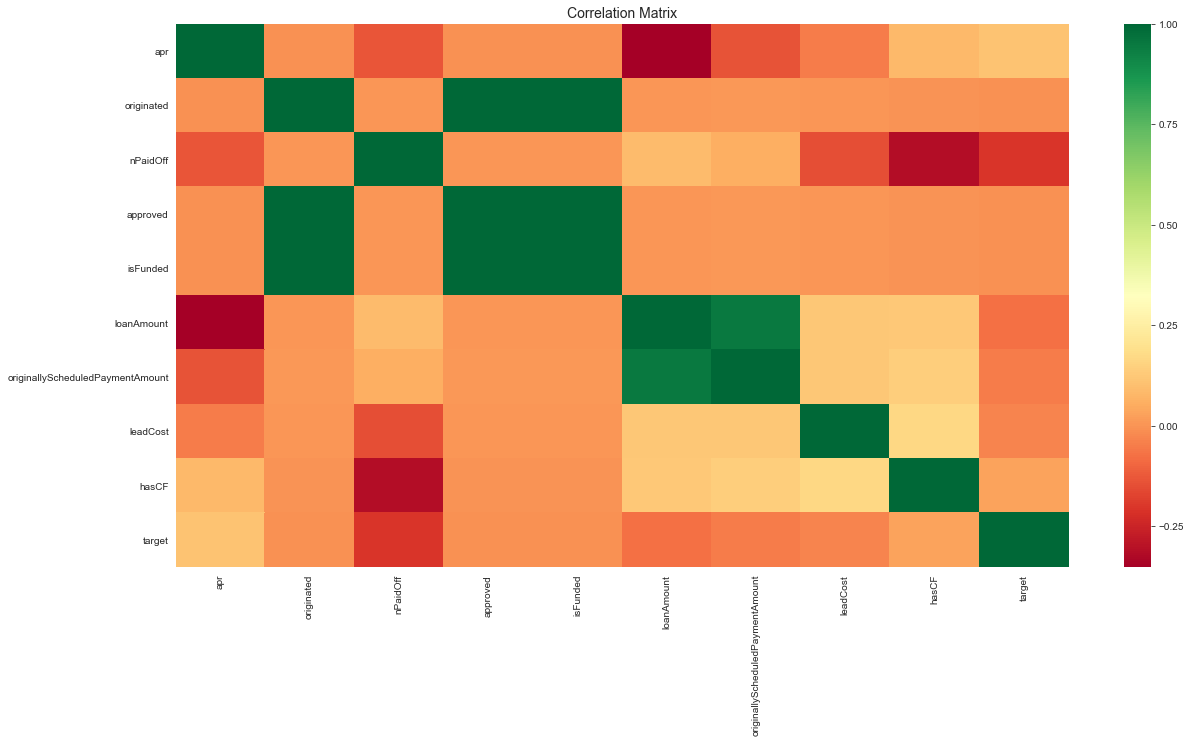

In [306]:
'''
# Heatmap to ease my process of checking correlations between features
# approved and isFunded seem to be perfectly coorelated, we will remove one of them to prevent multicollinearity issue
# loanAmount and originallyScheduledPaymentAmount seem to have a correlation higher than 0.9, hence we will remove 
# either of them as well 
'''
fig, ax = plt.subplots(figsize=(20,10))         
corr = loan.corr()
sns.heatmap(corr, cmap='RdYlGn', annot_kws={'size':30}, ax=ax)
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()


In [308]:
loan=loan[loan['isFunded']==1] #filter out loan that isn't funded, as we only want to focus those that are funded for our model later on

In [309]:
loan['day_origin'] = loan['originatedDate'].dt.day
loan['month_origin'] = loan['originatedDate'].dt.month
loan['year_origin'] = loan['originatedDate'].dt.year

[Text(0, 0.5, '(%)')]

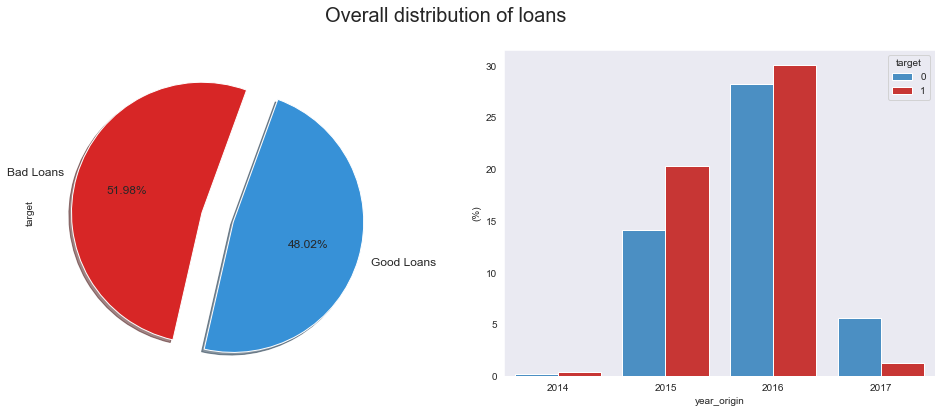

In [315]:
f, ax = plt.subplots(1,2, figsize=(17,6))

colors = ["#D72626","#3791D7"]
labels ="Bad Loans", "Good Loans"

plt.suptitle('Overall distribution of loans', fontsize=20)

loan["target"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)



palette = ["#3791D7", "#E01E1B"]

dashfig=sns.barplot(x="year_origin", y="loanAmount", hue="target", data=loan, palette=palette, estimator=lambda x: len(x) / len(loan) * 100)
fig1 = dashfig.get_figure()
ax[1].set(ylabel="(%)")

In [316]:
fig1.savefig("dashboardfig.png", dpi=200)

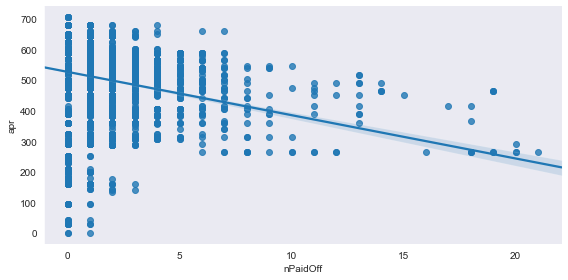

In [311]:
#Simple regression plot to check correlation between nPaidOff and apr, since heatmap earlier shows that these two are slightly negatively correlated
sns.set_style('dark')
sns.lmplot(x='nPaidOff',y='apr',data=loan,aspect=2,size=4)

In [210]:
loan['nPaidOff'].corr(loan['apr']) #weak correlation 

-0.13506712453114378

In [211]:
loan.isFunded.value_counts()

1    23795
Name: isFunded, dtype: int64

In [212]:
loan_0 = loan[loan['target']==0]
loan_1 = loan[loan['target']==1]

In [213]:
pd.DataFrame(loan_1['leadType'].value_counts()).reset_index()['leadType'].to_list()

[7532, 2158, 2122, 464, 69, 20, 3]

In [214]:
loan_1['leadType'].value_counts()

bvMandatory     7532
lead            2158
organic         2122
prescreen        464
rc_returning      69
california        20
repeat             3
Name: leadType, dtype: int64

In [215]:
leadType_1=pd.DataFrame(loan_1['leadType'].value_counts())

In [216]:
new_index=['bvMandatory', 'organic', 'lead', 'rc_returning','prescreen','california','lionpay','express','repeat','instant-offer']
leadType_1=leadType_1.reindex(new_index)

In [217]:
leadType_1.fillna(0,inplace=True)

In [219]:
leadType_0=pd.DataFrame(loan_0['leadType'].value_counts())

In [221]:
new_index=['bvMandatory', 'organic', 'lead', 'rc_returning','prescreen','california','lionpay','express','repeat','instant-offer']
leadType_0=leadType_0.reindex(new_index)

In [222]:
loan_0['leadType'].unique()

array(['prescreen', 'organic', 'bvMandatory', 'lead', 'rc_returning',
       'california', 'express', 'repeat', 'lionpay', 'instant-offer'],
      dtype=object)

In [223]:
#Organic lead type seem to have a higher distribution in good loans compared to bad loans. Further context required to provide a qualitative reason to why this is the case
#byMandatory lead type seem to have a higher distribution in bad loans compared to good loans

data = [
    go.Scatterpolar(
        mode='lines+markers',
      r = leadType_0.reset_index()['leadType'].to_list(),
      theta = ['bvMandatory', 'organic', 'lead', 'rc_returning','prescreen','california','lionpay','express','repeat','instant-offer'],
      fill = 'toself',
      name = 'Good Loans',
        line = dict(
        color = "#63AF63"
      ),
      marker = dict(
        color = "#B3FFB3",
        symbol = "square",
        size = 8
      ),
      subplot = "polar",
    ),
    go.Scatterpolar(
        mode='lines+markers',
      r = leadType_1.reset_index()['leadType'].to_list(),
      theta = ['bvMandatory', 'organic', 'lead', 'rc_returning','prescreen','california','lionpay','express','repeat','instant-offer'],
      fill = 'toself',
      name = 'Default Loans',
        line = dict(
        color = "#C31414"
      ),
      marker = dict(
        color = "#FF5050",
        symbol = "square",
        size = 8
      ),
      subplot = "polar2"
    )
]

layout = go.Layout(
    title="Lead Type Distribution",
    showlegend = True,
     paper_bgcolor = "rgb(255, 248, 243)",
    polar = dict(
      domain = dict(
        x = [0,0.4],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "clockwise"
      )
    ),
    polar2 = dict(
      domain = dict(
        x = [0.6,1],
        y = [0,1]
      ),
      radialaxis = dict(
        tickfont = dict(
          size = 8
        )
      ),
      angularaxis = dict(
        tickfont = dict(
          size = 8
        ),
        rotation = 90,
        direction = "clockwise"
      ),
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)


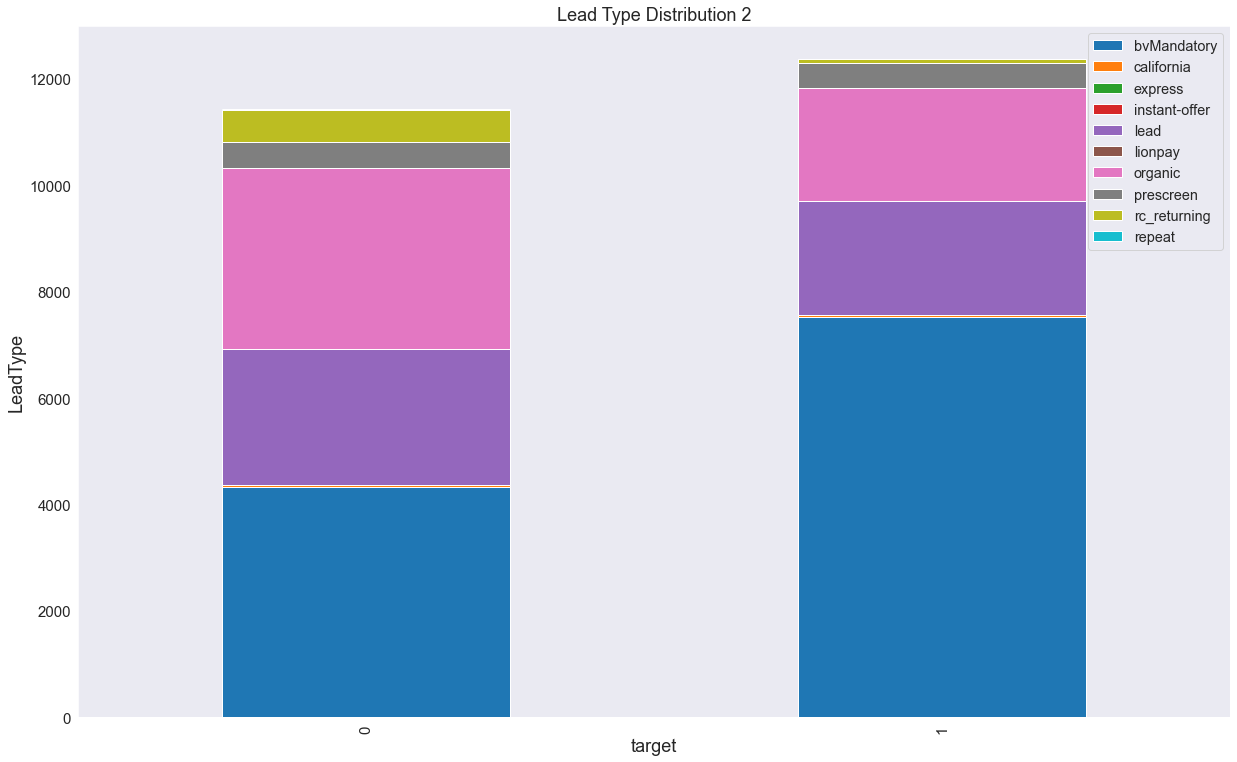

In [224]:
fig = plt.figure(figsize=(20,12))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
loan.groupby(['target','leadType']).size().unstack().plot(kind='bar', stacked=True, ax=axes)
axes.set_xlabel('target', fontsize=18)
axes.set_ylabel('LeadType', fontsize=18)
axes.set_title('Lead Type Distribution 2', fontsize=18)
axes.legend(loc=1, fontsize = 'x-large')
axes.tick_params(axis='both', which='major', labelsize=15)

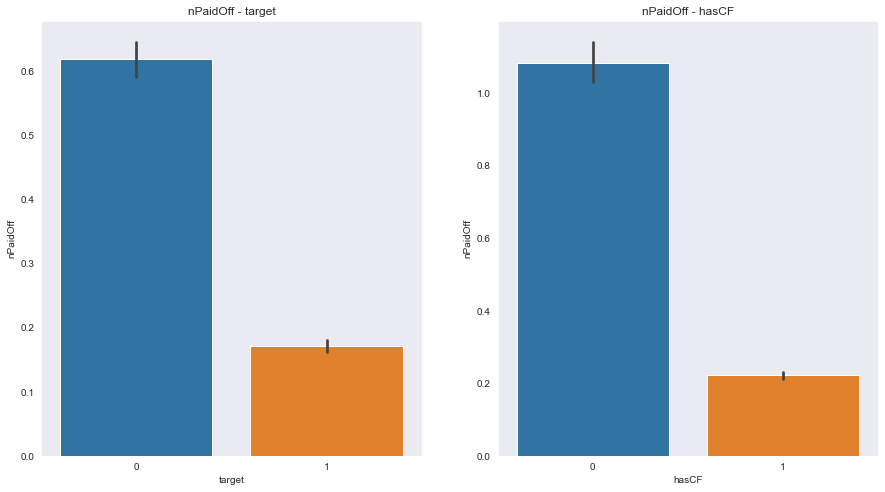

In [225]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
axes[0].set_title('nPaidOff - target')
axes[1].set_title('nPaidOff - hasCF')
sns.barplot(x='target',y='nPaidOff',data=loan,ax=axes[0]) #good loans has a higher mean of nPaidOff than default loans
sns.barplot(x='hasCF',y='nPaidOff',data=loan,ax=axes[1])  #loans without CF has a higher mean of nPaidOff than default loans 

In [226]:
payFreq_target_1 =pd.DataFrame(loan[loan['target']==1].groupby('payFrequency')['target'].count())
payFreq_target_0 =pd.DataFrame(loan[loan['target']==0].groupby('payFrequency')['target'].count())
new_index=['B','W','M','S','I']
payFreq_target_1=payFreq_target_1.reindex(new_index)
payFreq_target_0=payFreq_target_0.reindex(new_index)
payFreq_target_1['distribution']=(payFreq_target_1['target'].div(payFreq_target_1['target'].sum()))*100
payFreq_target_0['distribution']=(payFreq_target_0['target'].div(payFreq_target_0['target'].sum()))*100
payFreq_target_1.reset_index(inplace=True)
payFreq_target_0.reset_index(inplace=True)

In [227]:
payFreq_target_1

,payFrequency,target,distribution
0,B,7194,58.166235
1,W,3734,30.190815
2,M,776,6.274256
3,S,539,4.358021
4,I,125,1.010673


In [228]:
payFreq_target_0

,payFrequency,target,distribution
0,B,6717,58.781833
1,W,2858,25.010939
2,M,884,7.736064
3,S,678,5.933316
4,I,290,2.537849


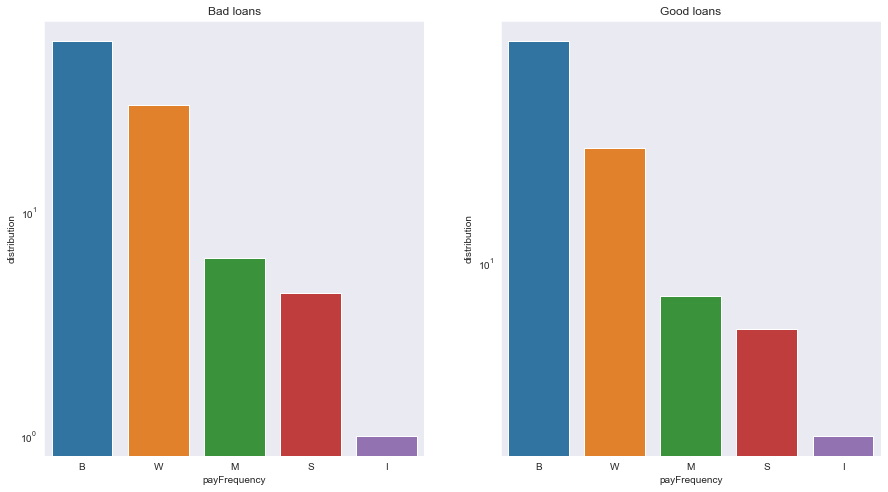

In [229]:
#Distribution of bad and good loans seem to be identical 

sns.set_style('dark')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
axes[0].set_title('Bad loans')
axes[1].set_title('Good loans')
g1 = sns.barplot(x='payFrequency',y='distribution',data=payFreq_target_1,ax=axes[0]) 
g1.set_yscale("log")
g2 = sns.barplot(x='payFrequency',y='distribution',data=payFreq_target_0,ax=axes[1]) 
g2.set_yscale("log")

In [230]:
loan.groupby('target')['fpStatus'].value_counts()

target  fpStatus 
0       Checked      10962
        Rejected       219
        Cancelled      196
        Skipped         50
1       Checked       8931
        Rejected      3316
        Skipped         79
        Cancelled       33
        Returned         1
Name: fpStatus, dtype: int64

In [231]:
pd.DataFrame(loan_0['fpStatus'].value_counts()).reset_index()['fpStatus'].to_list()

[10962, 219, 196, 50]

In [232]:
fpStatus_target_1 =pd.DataFrame(loan[loan['target']==1].groupby('fpStatus')['target'].count())
fpStatus_target_0 =pd.DataFrame(loan[loan['target']==0].groupby('fpStatus')['target'].count())
new_index=['Checked','Rejected','Cancelled','Skipped']
fpStatus_target_1=fpStatus_target_1.reindex(new_index)
fpStatus_target_0=fpStatus_target_0.reindex(new_index)
fpStatus_target_1.reset_index(inplace=True)
fpStatus_target_0.reset_index(inplace=True)

In [233]:
fpStatus_target_1

,fpStatus,target
0,Checked,8931
1,Rejected,3316
2,Cancelled,33
3,Skipped,79


In [234]:
fpStatus_target_0

,fpStatus,target
0,Checked,10962
1,Rejected,219
2,Cancelled,196
3,Skipped,50


In [235]:
fpStatus_target_1 =pd.DataFrame(loan[loan['target']==1].groupby('fpStatus')['target'].count())
fpStatus_target_0 =pd.DataFrame(loan[loan['target']==0].groupby('fpStatus')['target'].count())
new_index=['Checked','Rejected','Cancelled','Skipped']
fpStatus_target_1=fpStatus_target_1.reindex(new_index)
fpStatus_target_0=fpStatus_target_0.reindex(new_index)
fpStatus_target_1['distribution']=(fpStatus_target_1['target'].div(fpStatus_target_1['target'].sum()))*100
fpStatus_target_0['distribution']=(fpStatus_target_0['target'].div(fpStatus_target_0['target'].sum()))*100
fpStatus_target_1.reset_index(inplace=True)
fpStatus_target_0.reset_index(inplace=True)

In [236]:
fpStatus_target_1

,fpStatus,target,distribution
0,Checked,8931,72.263128
1,Rejected,3316,26.830650
2,Cancelled,33,0.267012
3,Skipped,79,0.639210


In [237]:
fpStatus_target_0

,fpStatus,target,distribution
0,Checked,10962,95.930690
1,Rejected,219,1.916514
2,Cancelled,196,1.715236
3,Skipped,50,0.437560


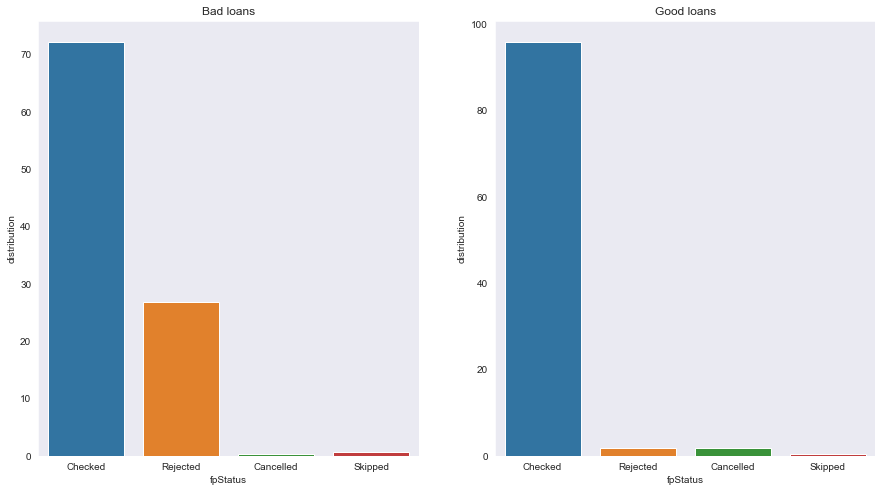

In [238]:
#Good loans has a higher proportion of 'checked' status compared to bad loans (95.9 vs 72.2)
#Bad loans has a way higher proportion of 'rejected' status compared to bad loans (26.8 vs 1.9)
sns.set_style('dark')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
axes[0].set_title('Bad loans')
axes[1].set_title('Good loans')
g1 = sns.barplot(x='fpStatus',y='distribution',data=fpStatus_target_1,ax=axes[0]) 
 
g2 = sns.barplot(x='fpStatus',y='distribution',data=fpStatus_target_0,ax=axes[1]) 


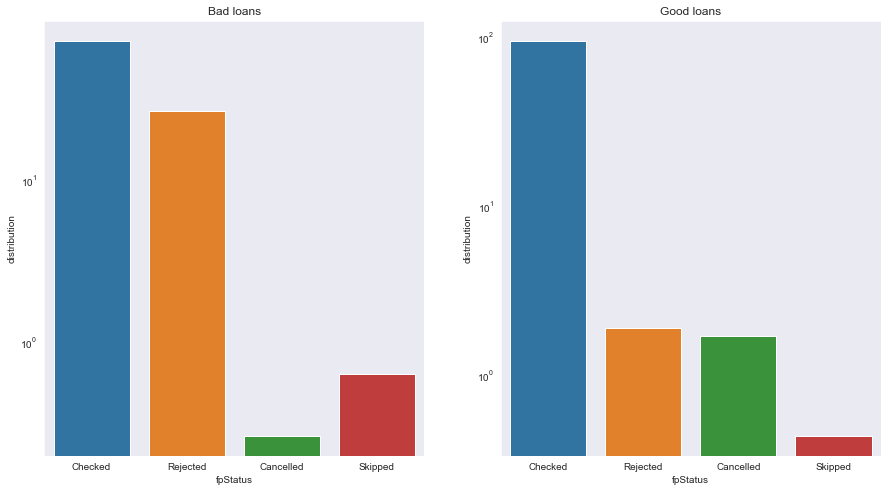

In [239]:
#Good loans has slighlty higher 'cancelled' status compared to bad loans, which slightly defies our inference (1.7-0.2)
#Bad loans has a higher proportion of 'skipped' status compared to good loans (0.6-0.43)
sns.set_style('dark')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
axes[0].set_title('Bad loans')
axes[1].set_title('Good loans')
g1 = sns.barplot(x='fpStatus',y='distribution',data=fpStatus_target_1,ax=axes[0]) 
g1.set_yscale("log") #scale to zoom in the distribution 
g2 = sns.barplot(x='fpStatus',y='distribution',data=fpStatus_target_0,ax=axes[1]) 
g2.set_yscale("log")

# Integrating underwriting table into our loan table
    a) I chose to include only clearfraudscore as one of our features for modelling 
    
    b) Created a lineplot and choropleth maps that depicts fraudscore across all that states of USA

In [241]:
clarity = pd.read_csv('clarity_underwriting_variables.csv')

In [242]:
loan=pd.merge(loan, clarity[['clearfraudscore','underwritingid']], left_on='clarityFraudId', right_on='underwritingid', how='left')

In [243]:
loan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadCost,fpStatus,clarityFraudId,hasCF,target,day_origin,month_origin,year_origin,clearfraudscore,underwritingid
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,0,Checked,569eb3a3e4b096699f685d64,1,0,20,1,2016,879.0,569eb3a3e4b096699f685d64
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,31,1,2017,835.0,58450a15e4b0bb9d6d7344c7
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,10,Checked,578f9346e4b0810ad5e7b72e,1,0,29,8,2016,624.0,578f9346e4b0810ad5e7b72e
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,0,Checked,56621584e4b0100e84141586,1,0,25,5,2016,770.0,56621584e4b0100e84141586
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,6,Rejected,NaN,0,0,26,5,2015,NaN,NaN


In [244]:
loan.drop('underwritingid',inplace=True,axis=1)

In [245]:
loan.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,day_origin,month_origin,year_origin,clearfraudscore
0,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19 22:07:36.778,True,2016-01-20 15:49:18.846,0.0,True,1,...,prescreen,0,Checked,569eb3a3e4b096699f685d64,1,0,20,1,2016,879.0
1,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31 17:48:17.381,True,2017-01-31 18:00:14.520,2.0,True,1,...,organic,0,Checked,58450a15e4b0bb9d6d7344c7,1,0,31,1,2017,835.0
2,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27 09:08:05.442,True,2016-08-29 15:05:04.014,0.0,True,1,...,bvMandatory,10,Checked,578f9346e4b0810ad5e7b72e,1,0,29,8,2016,624.0
3,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25 03:05:18.849,True,2016-05-25 15:11:36.260,3.0,True,1,...,organic,0,Checked,56621584e4b0100e84141586,1,0,25,5,2016,770.0
4,LL-I-01316580,2a10b2e04c5eec9a47a8cf5b9b81a2b8,W,590.0,2015-05-26 17:02:27.312,True,2015-05-26 18:45:48.024,0.0,True,1,...,bvMandatory,6,Rejected,NaN,0,0,26,5,2015,NaN


In [246]:
loan['target'].value_counts()

1    12368
0    11427
Name: target, dtype: int64

In [247]:
loan.isna().sum() #high amount of missing values in clearfraudscore, will impute them before modelling later

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originated                             0
originatedDate                         0
nPaidOff                              21
approved                               0
isFunded                               0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               8
clarityFraudId                      4542
hasCF                                  0
target                                 0
day_origin                             0
month_origin                           0
year_origin                            0
clearfraudscore                     4620
dtype: int64

In [248]:
state_fraud=pd.DataFrame(loan.groupby('state').mean()['clearfraudscore'])

In [249]:
state_fraud.reset_index(inplace=True)
state_fraud.dropna(inplace=True)

Text(0.5, 1.0, 'States on Fraud Score')

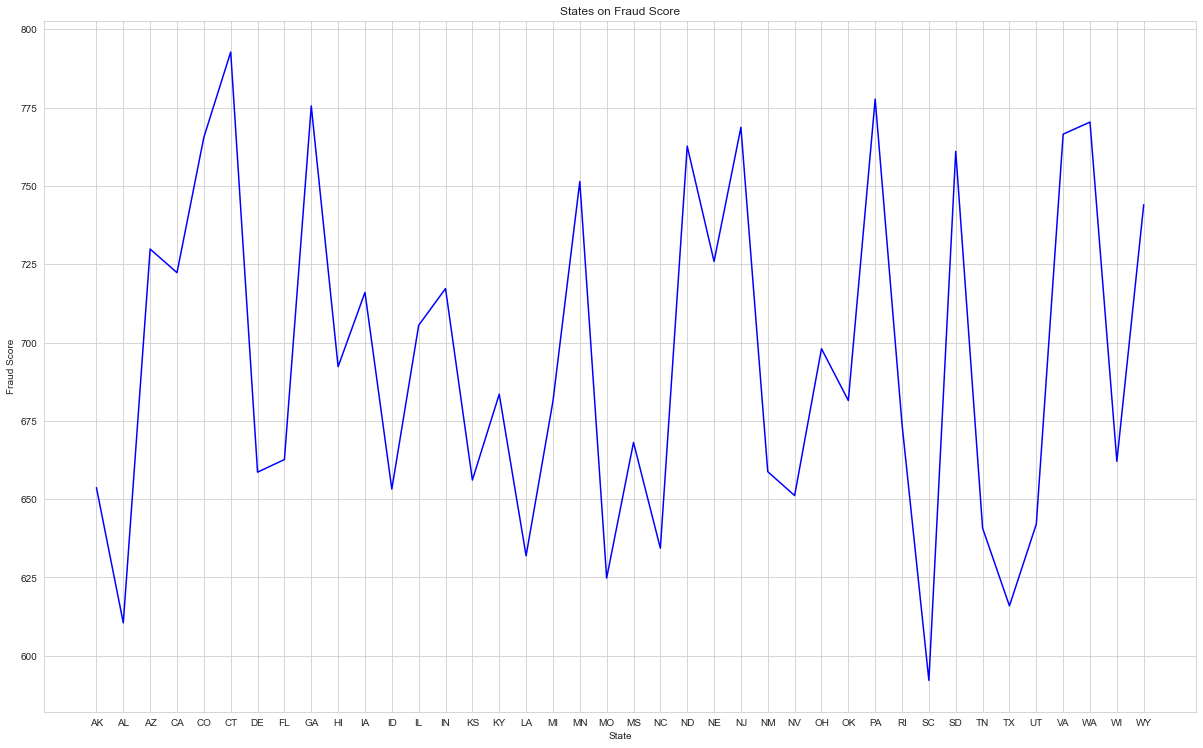

In [250]:
#Significant difference in state with the highest fraud score (Connecticut) compared to the state with the lowest fraud score (Sacremento)
sns.set_style('whitegrid')
x= state_fraud['state']
y = state_fraud['clearfraudscore']

fig = plt.figure(figsize=(20,12))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 


axes.plot(x, y, 'b')
axes.set_xlabel('State') 
axes.set_ylabel('Fraud Score')
axes.set_title('States on Fraud Score')

In [251]:
#A safe assumption from this map is that high-income states like California, Connecticut, Washtington DC tend to hold higher fraud score since there are more credit card users 
data = dict(type='choropleth', 
            colorscale = 'ylorrd',
            locations = state_fraud['state'],
            z = state_fraud['clearfraudscore'],
            locationmode = 'USA-states',
            text = state_fraud['state'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Fraud Score"}
            ) 
layout = dict(title = 'Fraud Score by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

In [252]:
loan['target'].value_counts()

1    12368
0    11427
Name: target, dtype: int64

In [253]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23795 entries, 0 to 23794
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            23795 non-null  object        
 1   anon_ssn                          23795 non-null  object        
 2   payFrequency                      23795 non-null  object        
 3   apr                               23795 non-null  float64       
 4   applicationDate                   23795 non-null  datetime64[ns]
 5   originated                        23795 non-null  bool          
 6   originatedDate                    23795 non-null  datetime64[ns]
 7   nPaidOff                          23774 non-null  float64       
 8   approved                          23795 non-null  bool          
 9   isFunded                          23795 non-null  int64         
 10  loanAmount                        23795 non-nu

# Feature Engineering certain features on our final table to prepare for modelling

    a) Drop identifiers and unwanted columns 
    
    b) Convert non numeric columns by either label encoding or oneHot 

In [254]:
#I would choose to label encode 'payFrequency' since it's an ordinal categorical variable 

In [255]:
from sklearn import preprocessing 

In [256]:
label_encoder = preprocessing.LabelEncoder() 

In [257]:
loan['payFrequency']= label_encoder.fit_transform(loan['payFrequency']) 

In [258]:
#I would choose to onehotcode/create dummy variable for state, lead type, and fpstatus since they are nominal variables 

In [259]:
state=pd.get_dummies(loan['state'],drop_first=True)
loan=pd.concat([loan,state],axis=1)
leadType=pd.get_dummies(loan['leadType'],drop_first=True)
loan=pd.concat([loan,leadType],axis=1)
fpStatus=pd.get_dummies(loan['fpStatus'],drop_first=True)
loan=pd.concat([loan,fpStatus],axis=1)

In [260]:

loan.drop(['state','leadType','fpStatus'],axis=1,inplace=True)

In [261]:
#multicollinearity issue, based on heatmap earlier
loan.drop('approved',inplace=True,axis=1)
loan.drop('loanAmount',inplace=True,axis=1)
loan.drop('originated',inplace=True,axis=1) 

In [262]:
#identifiers
loan.drop(['loanId','anon_ssn','clarityFraudId'],axis=1,inplace=True)

In [263]:
#unwanted 
loan.drop(['applicationDate','originatedDate'],axis=1,inplace=True)

#  Imputing Missing Values with KNN
    a) Dealing with missing values in clearfraudscore 
    
    b) I chose KNN to impute as it makes more sense than imputing with mean or simply dropping them in this case 

In [265]:
#The assumption behind using KNN for missing values is that a point value can be approximated by the values of the points that are closest to it, based on other variables.
from sklearn.impute import KNNImputer

In [266]:
imputer = KNNImputer(n_neighbors=2)


In [267]:
loan=imputer.fit_transform(loan)

In [268]:
loan=pd.DataFrame(loan)
loan.isnull().values.any()

False

In [269]:
loan.isna().sum()

0     0
1     0
2     0
3     0
4     0
     ..
60    0
61    0
62    0
63    0
64    0
Length: 65, dtype: int64

In [270]:
#Asssign X and y value for train test split; drops 'target' column for X
X = loan.drop(loan.iloc[:, [7]],axis=1)
y = loan.iloc[:, [7]]

In [271]:
loan.isnull().values.any()

False

#  Model building and evaluation 

    a) Built model with logistic regression 
    
    b) Evaluate model and see if it fits our business objective 
        

# Train test split 

In [272]:
X = loan.drop(loan.iloc[:, [7]],axis=1)
y = loan.iloc[:, [7]]

In [273]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=1)

In [274]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, precision_score, roc_auc_score

# Simple Logisitic Regression

In [275]:
from sklearn.linear_model import LogisticRegression

In [276]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
predictions=model.predict(X_test)
auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
    
print('\n auc score: {} \n recall score: {} \n accuracy score: {} \n precision score: {} '.format(auc, recall, accuracy, precision))


 auc score: 0.6929224605054436 
 recall score: 0.6788440567066522 
 accuracy score: 0.6925339683429051 
 precision score: 0.7100085543199316 


In [277]:
print (confusion_matrix(y_test,predictions))

[[2454 1017]
 [1178 2490]]


In [278]:
def plot_conf_matrix(conf_matrix):
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu" ,fmt='g',annot_kws={"size": 12})    
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

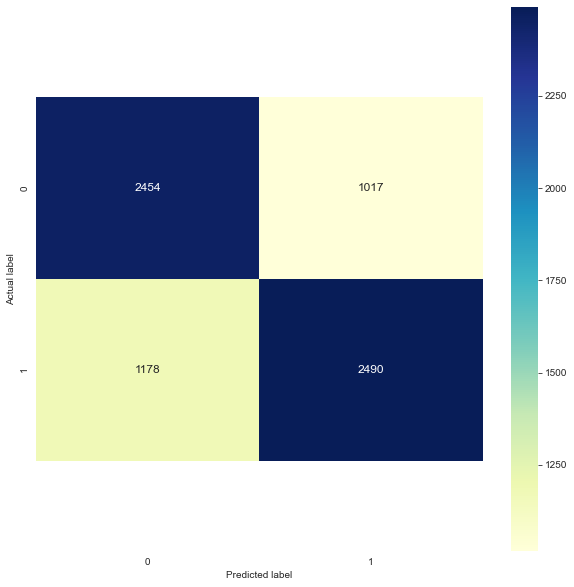

In [279]:
plot_conf_matrix(confusion_matrix(y_test,predictions))

# Logistic Regression after SMOTE

Despite having a considerably balanced data, I ran SMOTE to deal with any imbalances to see if there are any improvements in the result 

No further improvements were made on the performance

In [280]:
#from imblearn.over_sampling import SMOTE

In [281]:
#smt = SMOTE()
#X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

In [282]:
#model = LogisticRegression(max_iter=10000)
#model.fit(X_train_SMOTE, y_train_SMOTE)
#predictions=model.predict(X_test)
#auc = roc_auc_score(y_test, predictions)
#recall = recall_score(y_test, predictions)
#accuracy = accuracy_score(y_test, predictions)
#precision = precision_score(y_test, predictions)
    
#print('\n auc score: {} \n recall score: {} \n accuracy score: {} \n precision score: {} '.format(auc, recall, accuracy, precision))

In [283]:
#As expected, running SMOTE in our case shouldnt have much effect, since we already have a pretty balanced data to start off with

In [284]:
#print (confusion_matrix(y_test,predictions))

# Logistic Regression after using feature selection algorithm from sklearn 
to reduce feature dimensionality

No further improvements were made on the performance

In [285]:
#import sklearn.feature_selection

#select = sklearn.feature_selection.SelectKBest(k=30)
#selected_features = select.fit(X_train_SMOTE, y_train_SMOTE)
#indices_selected = selected_features.get_support(indices=True) 
#colnames_selected = [X.columns[i] for i in indices_selected] #retrieve column names from selected indices 

#X_train_selected = X_train_SMOTE[colnames_selected]
#X_test_selected = X_test[colnames_selected]

In [286]:
#colnames_selected

In [287]:
#model = LogisticRegression(max_iter=10000)
#model.fit(X_train_selected, y_train_SMOTE)
#predictions=model.predict(X_test_selected)
#auc = roc_auc_score(y_test, predictions)
#recall = recall_score(y_test, predictions)
#accuracy = accuracy_score(y_test, predictions)
#precision = precision_score(y_test, predictions)
    
#print('\n auc score: {} \n recall score: {} \n accuracy score: {} \n precision score: {} '.format(auc, recall, accuracy, precision))

In [288]:
# slightly better in overall score

# Final thoughts 

1) My model managed to predict with an AUC score of 69, which means there's a 69% chance my model can distinguish between bad loan and good loan (without feature engineering and inclusion of data from other tables, we only an AUC score of a little over 48%)  

2) Our recall score of 68% means that the occurence of False Negatives (FN) in our model is rather low. This is crucial as False Negatives are exceptionally costly in our case. Higher FN means actual bad loans are predicted to be good instead. This will cause Money Lion to lose unpaid/uncollected loan money, which is worse than losing clients on the interest rate or fee (False Positive)

3) Our model performed best without SMOTE, scaling (since we are doing a LogRes), and the use of Kbest

4) Further improvements: 
   
   a) Use other ML Algorithms like XGBoost, LightGBM, and SVM might boost model's performance 
  
   b) Further analysis can be conducted to derive better features from combining features (difference/sum/multiplication between two features)
   
   c) More data collection: collateral record 

# Total time spent: 

Understanding prompt and data given: 2 hours 

Planning and create data mining flowchart: 1 hour

Data Exploration and Visualization: 6 hours

Data transformation/ Feature Engineering: 4 hours

Building model and testing out models to optimize score: 2 hours 

Notebook cleaning and commenting: 2 hours 

Total time taken: 17 hours 